In [0]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision

In [0]:
!pip install --no-cache-dir -I pillow==5.3.0
!apt-get -qq install -y libsm6 libxext6 && pip install -q -U opencv-python

    100% |████████████████████████████████| 2.0MB 53.6MB/s 


In [0]:
# import resources
%matplotlib inline

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import PIL
import cv2
import torch
import torch.optim as optim
from torchvision import transforms, models

In [0]:
print(torch.__version__)
print(PIL.__version__)
print(cv2.__version__)

0.4.1
5.3.0
3.4.3


In [0]:
torch.cuda.is_available()

True

In [0]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!ls "/content/drive/My Drive/Colab Notebooks"

 Cat_Dog_data   me2.jpg   octopus.jpg	   'Untitled (1)'
 delaunay.jpg   me3.jpg   Untitled	   'Untitled (2)'
 hockney.jpg    me3.png   Untitled0.ipynb


In [0]:
# get the "features" portion of VGG19 (we will not need the "classifier" portion)
vgg = models.vgg19(pretrained=True).features

# freeze all VGG parameters since we're only optimizing the target image
for param in vgg.parameters():
    param.requires_grad_(False)

In [0]:
# move the model to GPU, if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace)
  (18): MaxPool2d(kernel_size=2, stride=2, padding=0, 

In [0]:
def load_image(img_path, max_size=400, shape=None):
    ''' Load in and transform an image, making sure the image
       is <= 400 pixels in the x-y dims.'''
    
    image = Image.open(img_path).convert('RGB')
    
    # large images will slow down processing
    print(image.size)
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)
    
    if shape is not None:
        size = shape
        
    in_transform = transforms.Compose([
                        transforms.Resize(size),
                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406), 
                                             (0.229, 0.224, 0.225))])

    # discard the transparent, alpha channel (that's the :3) and add the batch dimension
    image = in_transform(image)[:3,:,:].unsqueeze(0)
    
    return image

In [0]:
# load in content and style image
content = load_image('/content/drive/My Drive/Colab Notebooks/me2.jpg').to(device)
# Resize style to match content, makes code easier
style = load_image('/content/drive/My Drive/Colab Notebooks/delaunay.jpg', shape=content.shape[-2:]).to(device)

(1334, 1334)
(480, 586)


In [0]:
print(content.shape)
print(style.shape)

torch.Size([1, 3, 400, 400])
torch.Size([1, 3, 400, 400])


In [0]:
# helper function for un-normalizing an image 
# and converting it from a Tensor image to a NumPy image for display
def im_convert(tensor):
    """ Display a tensor as an image. """
    
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image

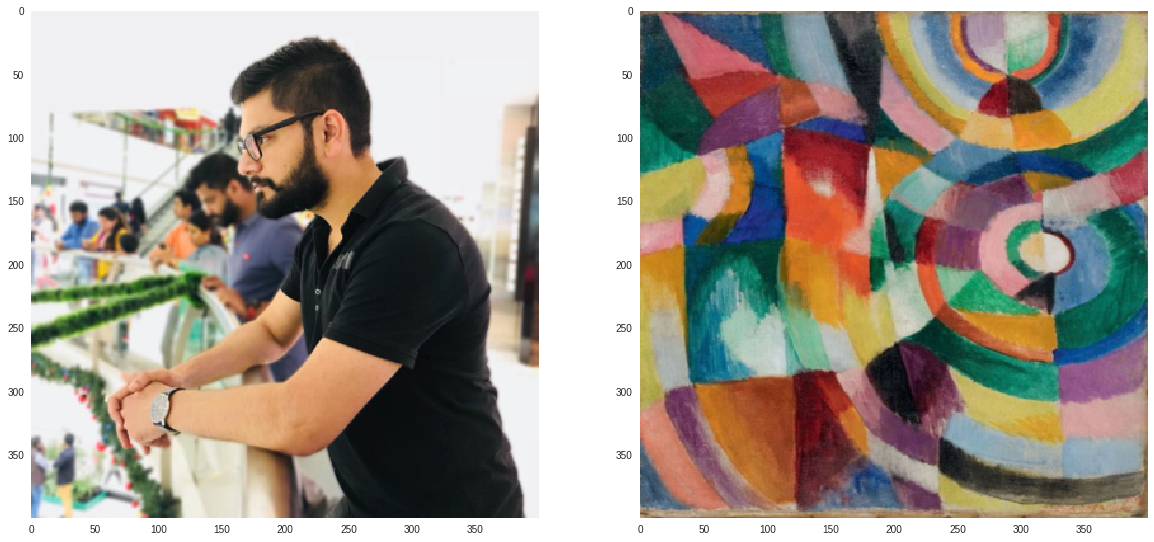

In [0]:
# display the images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
# content and style ims side-by-side
ax1.grid(False)
ax2.grid(False)
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(style))

In [0]:
# print out VGG19 structure so you can see the names of various layers
print(vgg)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace)
  (18): MaxPool2d(kernel_size=2, stride=2, padding=0, 

In [0]:
def get_features(image, model, layers=None):
    """ Run an image forward through a model and get the features for 
        a set of layers. Default layers are for VGGNet matching Gatys et al (2016)
    """
    
    ## TODO: Complete mapping layer names of PyTorch's VGGNet to names from the paper
    ## Need the layers for the content and style representations of an image
    if layers is None:
        layers = {'0': 'conv1_1',
                  '5': 'conv2_1',
                  '10': 'conv3_1',
                  '19': 'conv4_1',
                  '28': 'conv5_1',
                  '21': 'conv4_2'}
        
        
    ## -- do not need to change the code below this line -- ##
    features = {}
    x = image
    # model._modules is a dictionary holding each module in the model
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
            
    return features

In [0]:
def gram_matrix(tensor):
    """ Calculate the Gram Matrix of a given tensor 
        Gram Matrix: https://en.wikipedia.org/wiki/Gramian_matrix
    """
    
    ## get the batch_size, depth, height, and width of the Tensor
    ## reshape it, so we're multiplying the features for each channel
    ## calculate the gram matrix
    b_s, d, h, w = tuple(tensor.size())
    tensor = tensor.view(d, -1)
    gram = torch.mm(tensor, tensor.t())
    
    return gram 

In [0]:
# get content and style features only once before forming the target image
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)

# calculate the gram matrices for each layer of our style representation
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

# create a third "target" image and prep it for change
# it is a good idea to start of with the target as a copy of our *content* image
# then iteratively change its style
target = content.clone().requires_grad_(True).to(device)

In [0]:
[layer for layer in style_features]

['conv1_1', 'conv2_1', 'conv3_1', 'conv4_1', 'conv4_2', 'conv5_1']

In [0]:
# weights for each style layer 
# weighting earlier layers more will result in *larger* style artifacts
# notice we are excluding `conv4_2` our content representation
style_weights = {'conv1_1': 1.,
                 'conv2_1': 0.6,
                 'conv3_1': 0.4,
                 'conv4_1': 0.3,
                 'conv5_1': 0.2}

# you may choose to leave these as is
content_weight = 1  # alpha
style_weight = 1e6  # beta

50
100
150
200
250
300
350
400
Total loss:  9684829.0


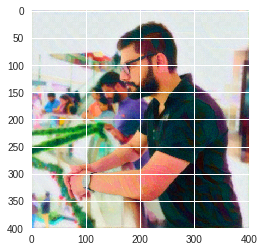

450
500
550
600
650
700
750
800
Total loss:  4133240.25


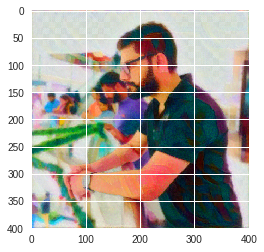

850
900
950
1000
1050
1100
1150
1200
Total loss:  2132923.5


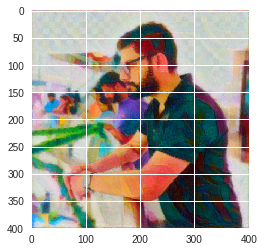

1250
1300
1350
1400
1450
1500
1550
1600
Total loss:  1190131.75


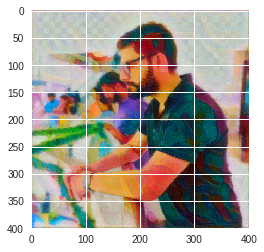

1650
1700
1750
1800
1850
1900
1950
2000
Total loss:  716510.625


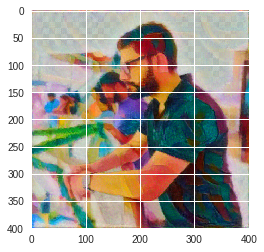

2050
2100
2150
2200
2250
2300
2350
2400
Total loss:  459724.25


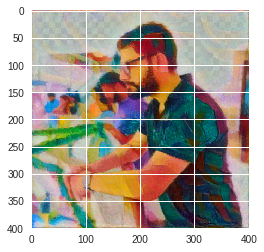

2450
2500
2550
2600
2650
2700
2750
2800
Total loss:  312350.8125


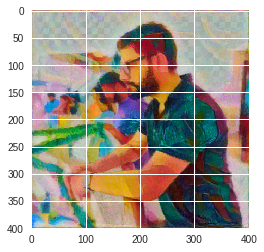

2850
2900
2950
3000
3050
3100
3150
3200
Total loss:  224815.578125


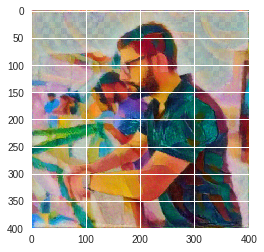

3250
3300
3350
3400
3450
3500
3550
3600
Total loss:  171524.359375


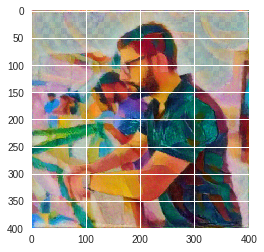

3650
3700
3750
3800
3850
3900
3950
4000
Total loss:  138565.84375


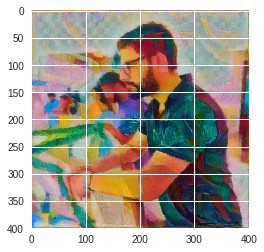

In [0]:
# for displaying the target image, intermittently
show_every = 400

# iteration hyperparameters
optimizer = optim.Adam([target], lr=0.003)
steps = 4000  # decide how many iterations to update your image (5000)

for ii in range(1, steps+1):
    
    ## TODO: get the features from your target image    
    ## Then calculate the content loss
    target_features = get_features(target, vgg)
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2']) ** 2)
    
    # the style loss
    # initialize the style loss to 0
    style_loss = 0
    # iterate through each style layer and add to the style loss
    for layer in style_weights:
        # get the "target" style representation for the layer
        target_feature = target_features[layer]
        _, d, h, w = target_feature.shape
        
        ## TODO: Calculate the target gram matrix
        target_gram = gram_matrix(target_feature)
        
        ## TODO:  get the "style" style representation
        style_gram = style_grams[layer]
        ## TODO: Calculate the style loss for one layer, weighted appropriately
        layer_style_loss = style_weights[layer] * torch.mean(((target_gram - style_gram) ** 2))
        
        # add to the style loss
        style_loss += layer_style_loss / (d * h * w)
        
        
    ## TODO:  calculate the *total* loss
    total_loss = content_weight * content_loss + style_weight * style_loss
    
    ## -- do not need to change code, below -- ##
    # update your target image
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    # display intermediate images and print the loss
    if  ii % 50 == 0:
        print(ii)
        
    if  ii % show_every == 0:
        print('Total loss: ', total_loss.item())
        plt.imshow(im_convert(target))
        plt.show()

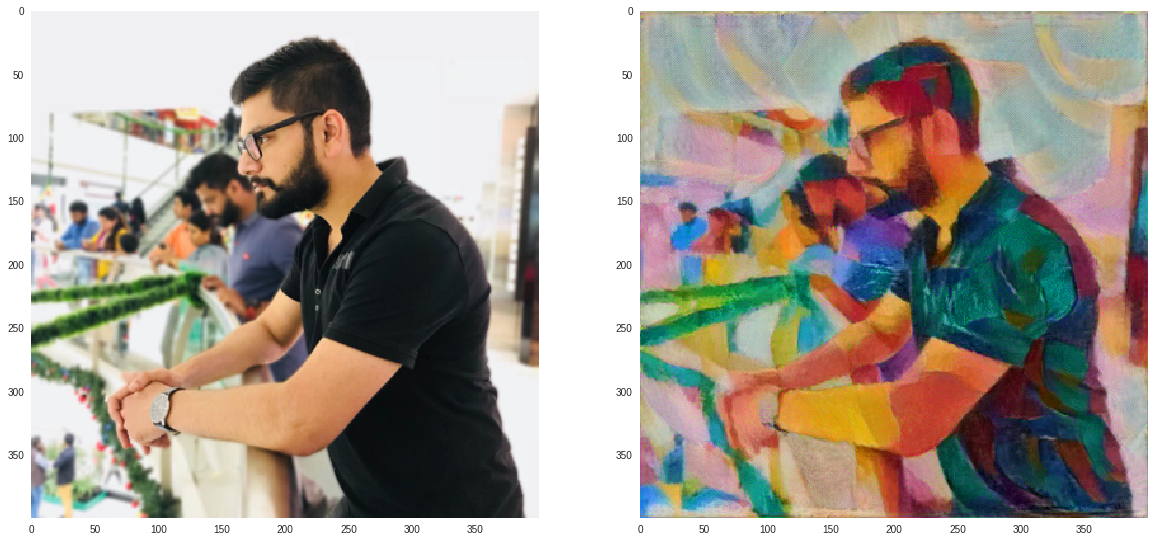

In [0]:
# display content and final, target image
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.grid(False)
ax2.grid(False)
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(target))

In [0]:
cv2.imwrite('/content/drive/My Drive/Colab Notebooks/me3.png', im_convert(target))

True

In [0]:
img = Image.fromarray(im_convert(target).astype(np.uint8))

In [0]:
img.save('/content/drive/My Drive/Colab Notebooks/me4.png')

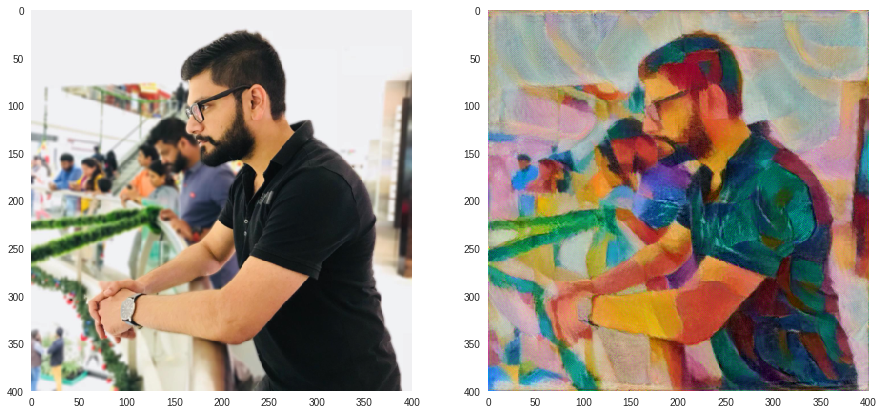

In [0]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 15))
ax1.grid(False)
ax2.grid(False)
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(target))